In [1]:
import os
import pandas as pd
import pickle
import collections
import matplotlib.pyplot as plt
from statistics import  mean
import math
import time
from typing import Union
%matplotlib inline

In [2]:
HOME = os.environ['HOME']
spath = f'{HOME}/webots_code/data/stats'
dpath = f'{HOME}/webots_code/data/stats/data'

## Creating Dataframe

In [3]:
def create_df(dpath:str)->pd.DataFrame:
    '''
    Creates a pandas dataframe from all the 
    pickled files
    '''
    data = pd.DataFrame(columns=['Time','Name','Model',
                                'GPS','Speed','BS'])

    for count,filename in enumerate(os.listdir(dpath)):
        ind = count
        with open(dpath+f'/{filename}','rb') as a:
            data.at[ind,'Time'] = pickle.load(a)
            data.at[ind,'Name'] = pickle.load(a)
            data.at[ind,'Model'] = pickle.load(a)
            data.at[ind,'GPS'] = pickle.load(a)
            data.at[ind,'Speed'] = pickle.load(a)
            data.at[ind,'BS'] = pickle.load(a)
        
        if (count+1)%1000 == 0:
            print(f'{count+1} samples has been added to dataframe')

    return data


In [4]:
try: 
    data = pd.read_pickle(spath+f'/sample_pd.pkl')
    print(f'Preprocessed dataframe already present')
except:
    data = create_df(dpath)

Preprocessed dataframe already present


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19343 entries, 0 to 19342
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Time       19343 non-null  object
 1   Name       19343 non-null  object
 2   Model      19343 non-null  object
 3   GPS        19343 non-null  object
 4   Speed      19343 non-null  object
 5   BS         19343 non-null  object
 6   veh_range  19343 non-null  int64 
 7   veh_dist   19343 non-null  object
dtypes: int64(1), object(7)
memory usage: 1.3+ MB


In [6]:
ncars = len(data['Name'].unique())

## Distribution of samples 

<BarContainer object of 57 artists>

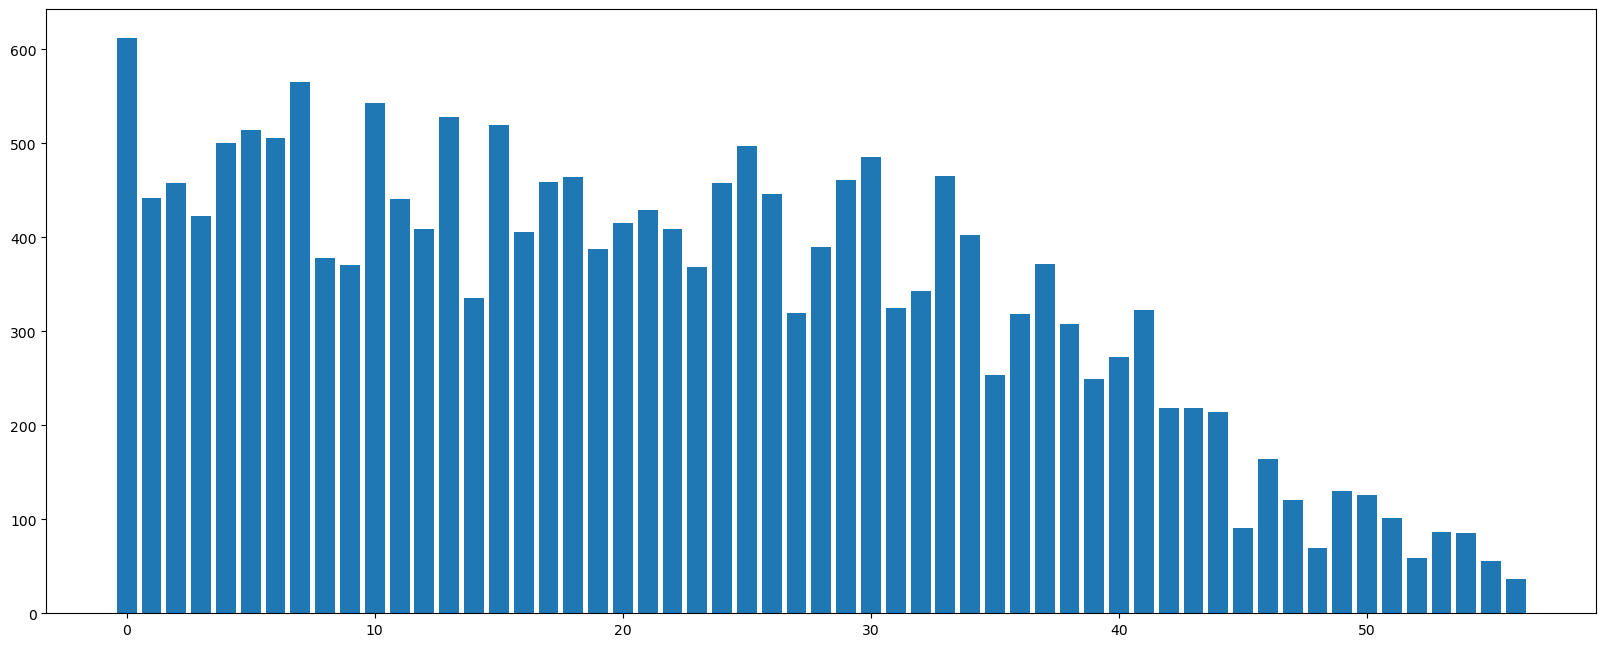

In [7]:
# Number of samples per car
car_dist = data['Name'].value_counts().to_dict()
#Sorting into list
per_car = [car_dist[f'SUMO vehicle {i}'] for i in range(0,len(data['Name'].unique()))]

plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['figure.dpi'] = 100 
plt.bar(range(0,len(data['Name'].unique())),per_car)

## Average Speed and speed distribution

In [8]:
speed = dict()
speed_dist = [0]*(round(data['Speed'][data['Speed']<100].max())+1)
for i in data.index.values:
    if data.at[i,'Speed'] > 100.00:
        print('Unusually high speed:',data.at[i,'Speed'],'Skipping')
        continue
    if data.at[i,'Name'] in speed.keys():
        speed[data.at[i,'Name']].append(data.at[i,'Speed'])
    else:
        speed[data.at[i,'Name']] = list()
        speed[data.at[i,'Name']].append(data.at[i,'Speed'])
    speed_dist[round(data.at[i,'Speed'])]+=1

Unusually high speed: 78068.80672991743 Skipping
Unusually high speed: 78695.2892424174 Skipping
Unusually high speed: 78134.47762469958 Skipping
Unusually high speed: 77858.93109594486 Skipping
Unusually high speed: 77980.65750597442 Skipping
Unusually high speed: 78381.98582266626 Skipping
Unusually high speed: 78759.87233467468 Skipping
Unusually high speed: 78297.27460896624 Skipping
Unusually high speed: 78143.91053920519 Skipping
Unusually high speed: 78102.58255860116 Skipping
Unusually high speed: 78073.19180697142 Skipping
Unusually high speed: 78457.88849706673 Skipping
Unusually high speed: 78303.48518655091 Skipping
Unusually high speed: 78069.60613856786 Skipping
Unusually high speed: 78143.35042581757 Skipping
Unusually high speed: 78227.24576993138 Skipping
Unusually high speed: 78648.48772039643 Skipping
Unusually high speed: 78754.50413971831 Skipping
Unusually high speed: 78327.5200994015 Skipping
Unusually high speed: 78229.9879820661 Skipping
Unusually high speed: 7

### Speed Distribution

Max speed is 48.34830292230978


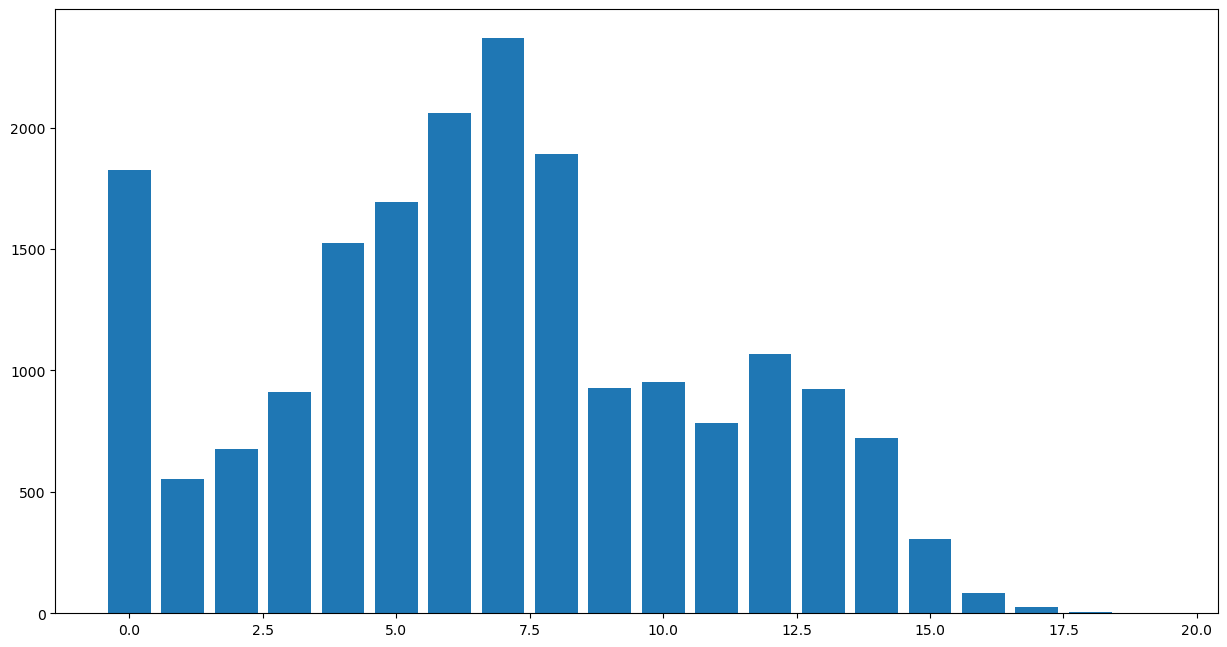

In [23]:
plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams['figure.dpi'] = 100
plt.bar(range(20),speed_dist[:20])
print('Max speed is',data['Speed'][data['Speed']<100].max())

In [10]:
avg_speed = list()
for i in range(len(data['Name'].unique())):
    avg_speed.append(mean(speed[f'SUMO vehicle {i}']))

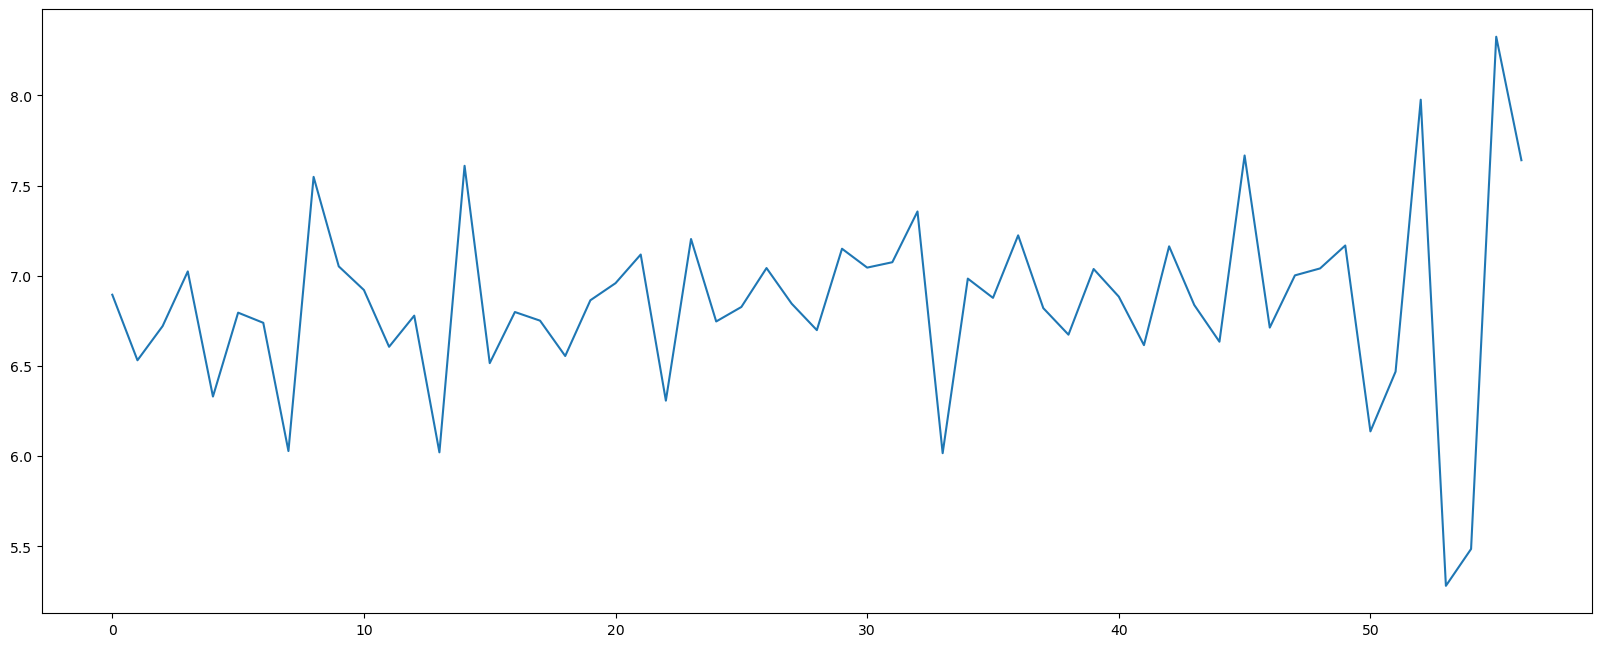

In [11]:
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['figure.dpi'] = 100
plt.plot(range(ncars),avg_speed)

## Surrounding vehicles

### For each sample
Calculating surrounding vehciles for each sample

In [12]:
timestep = 0.128
gpath = f'{HOME}/webots_code/data/stats/gps'
lrange = 120

#Creating new column for veh count
# data['veh_range'] = [0]*len(data)

In [13]:
# Determining the distance between car and transmitter in meter
# TO-DO : Consider height while calculating distance
def dist_gps(gps1, gps2):
    lat1, lon1, _ = gps1
    lat2, lon2, _ = gps2
    R = 6371000  # radius of Earth in meters
    phi_1 = math.radians(lat1)
    phi_2 = math.radians(lat2)

    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2.0) ** 2 + \
        math.cos(phi_1) * math.cos(phi_2) * \
        math.sin(delta_lambda / 2.0) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

In [14]:
def read_gps(gpath)-> Union[pd.DataFrame]:
    '''
    Read all the GPS dataset and store
    it in RAM, for faster exec
    '''
    gps_pd = []
    for filename in os.listdir(gpath):
        gps_pd.append(pd.read_feather(
                        gpath+f'/{filename}'))
    
    return gps_pd

In [15]:
# gps_pd = read_gps(gpath)

In [16]:
# #Iterating over all the vehicle GPS data
# start = time.time()
# veh_dist = list()
# for i in data.index.values:
#     siml_time = data.at[i,'Time']
#     i_dist = list()
#     for gps_entry in gps_pd: 
#         # Checking for the position of the vehicle in that timestep
#         entry = gps_entry[
#                     ((data.at[i,'Time'] - timestep) < gps_entry['timestep']) &
#                     (gps_entry['timestep'] <= data.at[i,'Time'])
#                     ]
#         if entry.empty : 
#             continue
        
#         if len(entry) > 1:
#             entry = entry[entry['timestep']==siml_time]
        
#         # Calculating distance between vehicles
#         dist = dist_gps(data.at[i,'GPS'],entry['gps'].values[0])
#         dist = round(dist,2)
#         if dist < lrange and dist!=0:
#             data.at[i,'veh_range'] +=1         #For number of vehicles in range
#             i_dist.append(dist) #Capturing the distance of each vehicle
    
#     veh_dist.append(i_dist)
#     if (i)%5000 == 0:
#         print(f'{i+1} samples processed',f'Time taken {time.time()-start}')
# data['veh_dist'] = veh_dist

In [17]:
# # Saving dataframe
# savepath = f'{HOME}/webots_code/data/stats/sample_pd.pkl'
# data.to_pickle(savepath)

In [18]:
# data

### Load pre processed data

<BarContainer object of 20 artists>

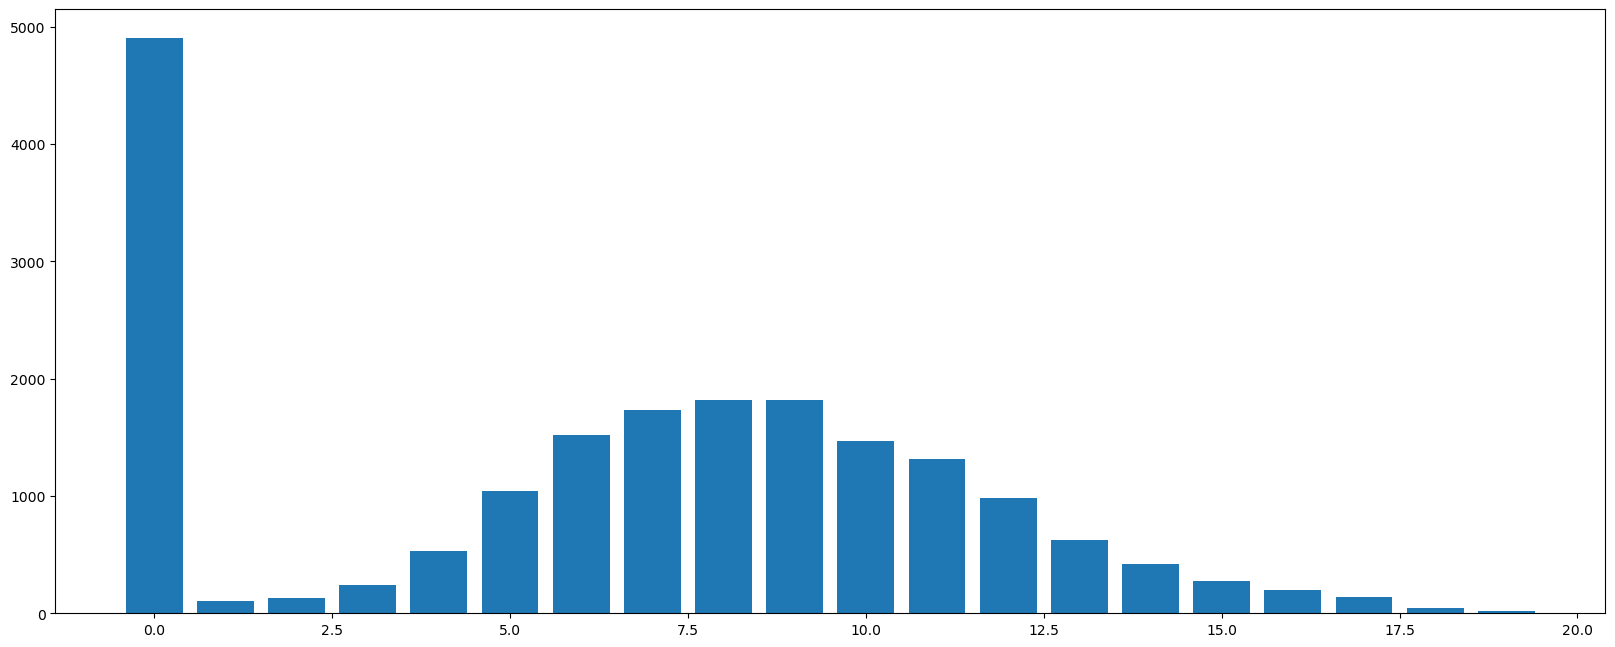

In [19]:
occr = [0]*(data['veh_range'].max()+1)

for i in data.index.values:
    occr[data.at[i,'veh_range']]+=1

plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['figure.dpi'] = 100
plt.bar(range(data['veh_range'].max()+1),occr)

1 samples has been processed Time taken 0.00023937225341796875
3001 samples has been processed Time taken 0.06269478797912598
6001 samples has been processed Time taken 0.11698460578918457
9001 samples has been processed Time taken 0.1603701114654541
12001 samples has been processed Time taken 0.20055341720581055
15001 samples has been processed Time taken 0.24738025665283203
18001 samples has been processed Time taken 0.28783631324768066


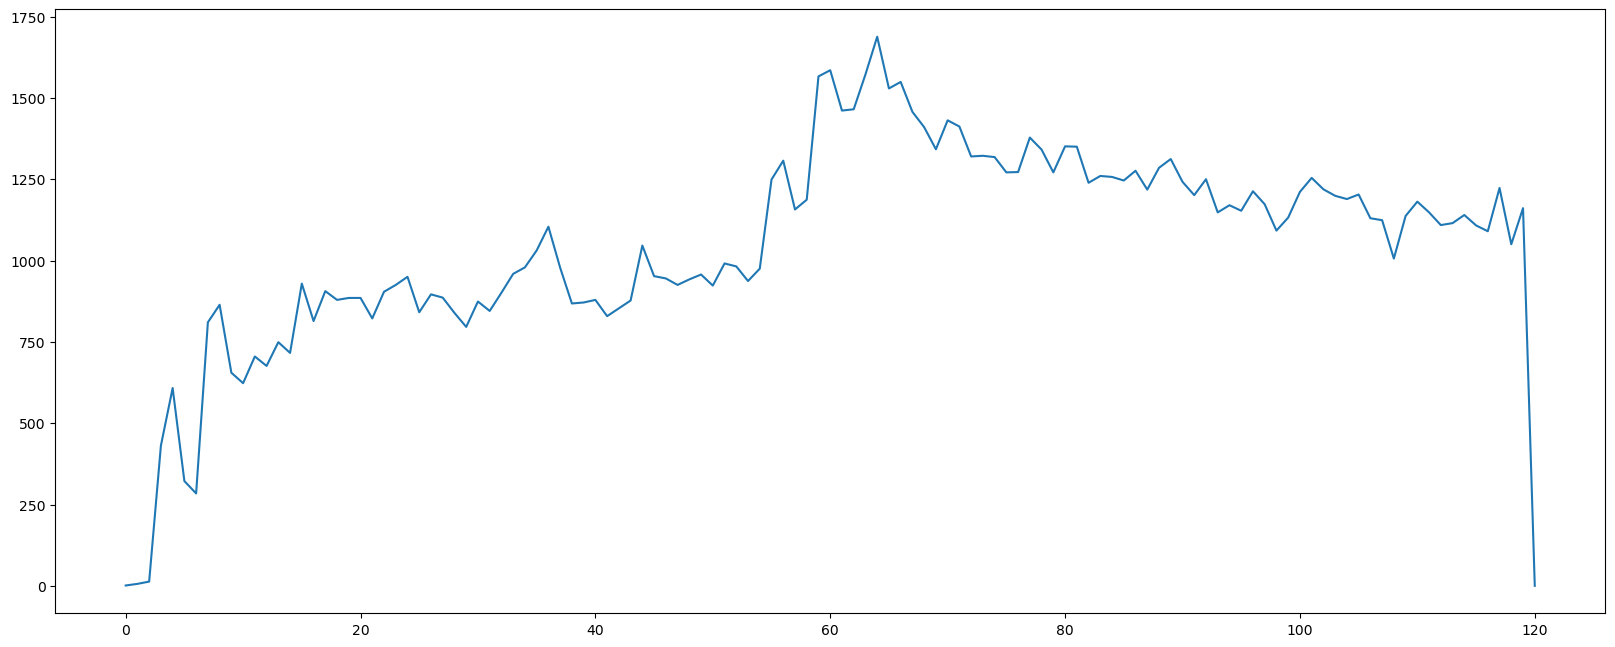

In [20]:
dist = [0]*121
start = time.time()
for i in data.index.values:
    for j in data.at[i,'veh_dist']:
        dist[int(j)] +=1
    
    if (i)%3000 == 0:
        print(f'{i+1} samples has been processed',f'Time taken {time.time()-start}')
        
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['figure.dpi'] = 100
plt.plot(range(0,121),dist)

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19343 entries, 0 to 19342
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Time       19343 non-null  object
 1   Name       19343 non-null  object
 2   Model      19343 non-null  object
 3   GPS        19343 non-null  object
 4   Speed      19343 non-null  object
 5   BS         19343 non-null  object
 6   veh_range  19343 non-null  int64 
 7   veh_dist   19343 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.0+ MB
